<p style="font-size:19px; text-align:left;"><i>Advanced Applications of Generative AI in Actuarial Science: Case Studies Beyond ChatGPT</i></p>
<p style="font-size:25px; text-align:left; font-weight:bold;">Case Study: Car Damage Classification and Localization with Fine-Tuned Vision-Enabled LLMs</p>
<p style="font-size:19px; text-align:left; margin-top: -10px; margin-bottom: 15px;">Simon Hatzesberger (<a href="mailto:shatzesberger@deloitte.de">shatzesberger@deloitte.de</a>), Iris Nonneman (<a href="mailto:irisnonneman@gmail.com">irisnonneman@gmail.com</a>)
<p style="font-style:italic; font-size: 19px">Date: May 11, 2025</p>

<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Table of Contents</h1>

[1. Overview and Key Takeaways](#overview_and_key_takeaways)

[2. Environment Setup and Initial Data Exploration](#environment_setup_and_initial_data_exploration)

[3. Primary Objective: Damage Type Classification](#primary_objective_damage_type_classification) <br>
&emsp;&emsp;&emsp;[3.1 Damage Classification Using a Convolutional Neural Network](#damage_classification_using_a_convolutional_neural_network) <br>
&emsp;&emsp;&emsp;[3.2 Damage Classification Using a Non-Fine-Tuned Large Language Model](#damage_classification_using_a_non-fine-tuned_large_language_model) <br>
&emsp;&emsp;&emsp;[3.3 Damage Classification Using a Fine-Tuned Large Language Model](#damage_classification_using_a_fine-tuned_large_language_model) <br>
&emsp;&emsp;&emsp;[3.4 Evaluating and Comparing Model Performance](#evaluating_and_comparing_model_performance)

[4. Secondary Objective: Identifying Damage Location](#secondary_objective_identifying_damage_location)

<h1 id="overview_and_key_takeaways" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">1. Overview and Key Takeaways</h1>

This case study explores how Large Language Models can improve both the classification and contextual understanding of car damage from images – an important task in automotive insurance, particularly for claims processing and risk assessment. Traditional computer vision methods, such as Convolutional Neural Networks (CNNs), have demonstrated strong performance in static image classification. However, these models often struggle to additionally incorporate contextual information that is valueable for insurance applications, such as precisely localizing damage, evaluating its severity, and accounting for external factors such as lighting and weather conditions at the time of capture.

To address these limitations, we employ OpenAI's GPT-4o, a vision-enabled Large Language Model that integrates image recognition with natural language understanding. By fine-tuning this model on a domain-specific dataset of labeled car damage images, we achieve classification performance that is comparable to traditional models while also providing richer contextual insights. This enhanced capability allows the model to distinguish, for example, between minor glass damage on a side window and a fully shattered windshield.

Beyond car damage analysis, this approach demonstrates broad applicability across various visual tasks in insurance. Its flexibility extends to medical image analysis, fraud detection in claims and invoices, and roof damage assessment in household and commercial property insurance, among others. Notably, the [INS-MMbench dataset](https://github.com/FDU-INS/INS-MMBench) provides a diverse collection of images covering these and other insurance-related tasks.

The key takeaways for actuarial practice from this case study are as follows:

- **Fine-tuning a vision-enabled LLM on domain-specific data can significantly improve classification performance**, as demonstrated in our experiments, where off-the-shelf models provide a solid baseline. Such a benefit from fine-tuning applies not only to visual tasks but usually also to textual applications.

- **LLMs with vision capabilities can** not only classify images but also **capture contextual details** and even perform optical character recognition (OCR). While traditional CNNs are effective at object recognition, they struggle with contextual analysis. LLMs, on the other hand, provide actuaries with a holistic assessment of image information and can even offer preliminary estimates of damage severity and repair costs.

- The **use of Structured Outputs ensures that model predictions adhere to predefined categories**, eliminating inconsistencies and improving reliability. In (car damage) classification, this guarantees that each prediction corresponds to one of the prespecified (damage) categories.

- A **key advantage of LLMs is their ease of use** compared to CNNs, which require expertise in model architecture and optimization. With fine-tuning, LLMs achieve high-quality results with minimal engineering effort, enabling actuaries to integrate AI-driven visual analysis into their workflows without specialized deep learning knowledge. On the downside, the fine-tuning process for LLMs may take significantly longer than training a CNN.

The remainder of this notebook is organized as follows. [Section 1](#overview_and_key_takeaways) provides an overview of the case study along with key takeaways. [Section 2](#environment_setup_and_initial_data_exploration) describes the environment setup and conducts an initial exploration of the dataset. [Section 3](#primary_objective_damage_type_classification) focuses on the primary objective of classifying damage types, beginning with a Convolutional Neural Network ([Subsection 3.1](#damage_classification_using_a_convolutional_neural_network)), progressing to a non-fine-tuned Large Language Model ([Subsection 3.2](#damage_classification_using_a_non-fine-tuned_large_language_model)), and culminating with a fine-tuned Large Language Model ([Subsection 3.3](#damage_classification_using_a_fine-tuned_large_language_model)). Model performance is evaluated and compared in [Subsection 3.4](#evaluating_and_comparing_model_performance). [Section 4](#secondary_objective_identifying_damage_location) addresses the secondary objective of identifying car damage locations, illustrating the contextual understanding capabilities of vision-enabled Large Language Models.

<h1 id="environment_setup_and_initial_data_exploration" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">2. Environment Setup and Initial Data Exploration</h1>

In this section, we set up the computational environment by importing necessary libraries, defining key constants, and loading configuration details. We also load and explore the dataset, which includes images of car damages along with associated metadata and classification labels. The initial setup and data exploration involve examining the target variable distribution and partitioning the data into training, validation, and test subsets for the machine learning task.

The following code imports a comprehensive suite of libraries for data processing, visualization, machine learning, deep learning, and API communications. In addition, we set a constant `RANDOM_SEED` for reproducibility.

In [1]:
# Essential libraries for data processing and analysis
import numpy as np
import pandas as pd

# Libraries for file operations, pattern matching, and in-notebook display
import os

# Libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Libraries for machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Libraries for deep learning with PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Library for image processing
from PIL import Image

# Libraries for randomness and progress tracking
from tqdm import tqdm

# Libraries for data serialization
import base64
import json

# Library for loading datasets from Kaggle
import kagglehub

# Libraries for structured data handling and type hints
from pydantic import BaseModel
from typing import Optional, Literal

# Library for accessing OpenAI models
import openai

# Configure pandas display options for enhanced readability
pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

# Random seed initialization
RANDOM_SEED = 42

Next, we set up the OpenAI API client by retrieving the API key from a previously stored environment variable named `OPENAI_API_KEY`. Alternatively, the API key can also be loaded from a text file or hard-coded directly into the code, though storing it in an environment variable is the recommended practice for security reasons. The API key must be obtained by signing up on the OpenAI platform. Note that using the OpenAI API incurs costs; detailed information can be found on [OpenAI’s pricing page](https://openai.com/pricing).


In [2]:
# Set up the OpenAI client for API communication
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In this case study, we use a dataset on car damages from a [Kaggle competition hosted by Analytics Vidhya](https://www.kaggle.com/datasets/imnandini/analytics-vidya-ripik-ai-hackfest), a platform dedicated to data science education and challenges. The dataset contains thousands of car images, each labeled with one of six damage categories: crack, scratch, tire flat, dent, glass shatter, or lamp broken. The following code snippet uses the `kagglehub` library to download the latest version of the dataset directly from Kaggle. Note that you must have a Kaggle account and configure your Kaggle environment (for example, by placing your Kaggle API credentials in the appropriate location) to access and import the dataset directly.

In [3]:
# Download latest version from Kaggle
path = kagglehub.dataset_download("imnandini/analytics-vidya-ripik-ai-hackfest")

In the following code, we load the dataset and adjust the label IDs, shifting them from the range 1–6 to 0–5 for compatibility with our CNN implementation. Additionally, we create a mapping to convert these numerical labels into descriptive text for clearer interpretation during model evaluation. Finally, we display eight samples (using `random_state=RANDOM_SEED+143`) of the resulting dataset to provide an initial overview of the data.

In [4]:
# Load and preprocess labels
csv_path = os.path.join(path, "train/train/train.csv")
df = pd.read_csv(csv_path)

# Rename and shift IDs from 1–6 to 0–5
df.rename(columns={'label': 'label_id'}, inplace=True)
df['label_id'] = df['label_id'] - 1

# Map numeric IDs to descriptive text
label_mapping = {
    0: "crack",
    1: "scratch",
    2: "tire flat",
    3: "dent",
    4: "glass shatter",
    5: "lamp broken"
}
df['label_text'] = df['label_id'].map(label_mapping)

# Sample eight rows reproducibly for a quick look
OFFSET = 143
sample_preview = df.sample(8, random_state=RANDOM_SEED + OFFSET)
display(sample_preview)

,image_id,filename,label_id,label_text
4791,4792,4792.jpg,1,scratch
3370,3371,3371.jpg,5,lamp broken
4,5,5.jpg,4,glass shatter
2172,2173,2173.jpg,2,tire flat
5451,5452,5452.jpg,1,scratch
6055,6056,6056.jpg,4,glass shatter
2856,2857,2857.jpg,3,dent
6594,6595,6595.jpg,0,crack


The dataset contains both tabular metadata and corresponding JPEG images. Below, we display the images associated with the tabular data above to provide an initial visual impression of each damage type.

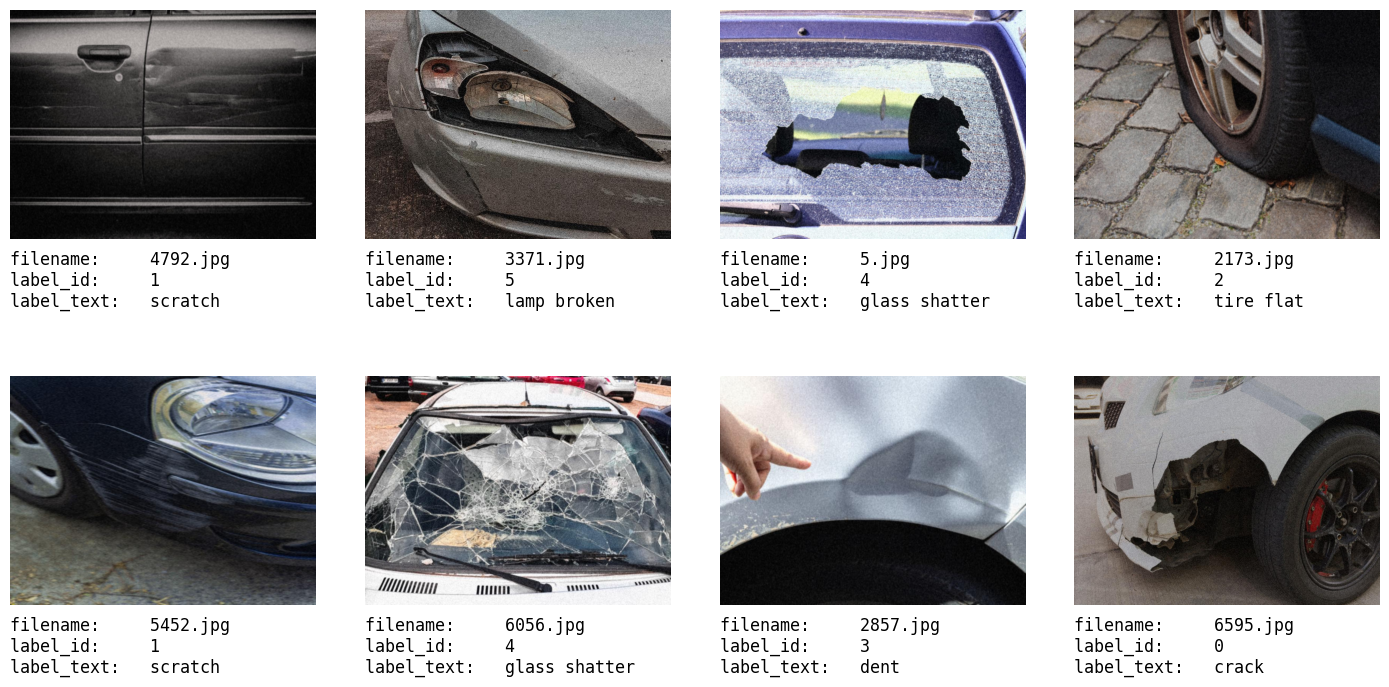

In [5]:
# Define the folder path for the images corresponding to the filenames of df
image_folder = os.path.join(path, "train/train/images/")

# Prepare to display the images in a 2x4 grid
num_images = len(sample_preview)
num_cols = 4
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 8))

# Iterate through the eight samples in sample_preview
for idx, (_, row) in enumerate(sample_preview.iterrows()):
    # Calculate the row and column indices for the current subplot
    grid_row = idx // num_cols
    grid_col = idx % num_cols

    # Get metadata for the current image
    filename = row['filename']
    label_id = row['label_id']
    label_text = row['label_text']

    # Open image and display it
    with Image.open(os.path.join(image_folder, filename)) as img:
        axs[grid_row, grid_col].imshow(img)
        axs[grid_row, grid_col].axis('off')

    # Add metadata as left-aligned text below the image
    axs[grid_row, grid_col].text(
        0, -0.05,
        f"filename:     {filename}\n"
        f"label_id:     {label_id}\n"
        f"label_text:   {label_text}",
        fontsize=12,
        va='top',
        ha='left',
        transform=axs[grid_row, grid_col].transAxes,
        wrap=True,
        fontfamily='monospace'
    )

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


To better understand the distribution of damage types in the dataset, we create a frequency table that lists each label's absolute count alongside its relative percentage (in the order as in `label_mapping`). This table highlights any class imbalances and shows exactly how common each type of damage is.

In [6]:
# Define the correct order according to label_mapping
label_order = ["crack", "scratch", "tire flat", "dent", "glass shatter", "lamp broken"]

# Count occurrences of each label_text and reorder
abs_counts = (
    df['label_text']
      .value_counts()
      .reindex(label_order, fill_value=0)
)

# Compute relative frequencies (as percentages)
rel_freq = (abs_counts / len(df) * 100).round(2)

# Build a summary table
freq_table = pd.DataFrame({
    'Absolute Frequency': abs_counts,
    'Relative Frequency (%)': rel_freq
})

# Display the table
display(freq_table)

,Absolute Frequency,Relative Frequency (%)
label_text,,
crack,171,2.38
scratch,2349,32.62
tire flat,534,7.42
dent,2079,28.88
glass shatter,1185,16.46
lamp broken,882,12.25


The dataset is notably imbalanced, with `scratch` and `dent` being the most frequent damage types, collectively accounting for over 60% of the dataset, while `crack` appears relatively infrequently at just 2.38%.

To speed up the model training process and minimize fine-tuning costs, we reduce the dataset to a randomly selected subset of 1,500 samples, ensuring a diverse representation of damage types. We then apply stratified sampling to maintain consistent label distributions across the training (60%, 900 samples), validation (20%, 300 samples), and test (20%, 300 samples) sets.

In [7]:
# Sample 1500 entries from the original dataframe
df_sampled = df.sample(1500, random_state=RANDOM_SEED).reset_index(drop=True)

# Split the data into train (60%), validation (20%), and test (20%) sets
df_train, df_test = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['label_id'], random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_train, test_size=0.25, stratify=df_train['label_id'], random_state=RANDOM_SEED)

Finally, we present a grouped bar chart showing the relative frequencies of each damage type in the original dataset, as well as in the training, validation, and test subsets (with sample sizes noted in the legend). This visualization lets us verify that our stratified splits preserve the overall class distribution.

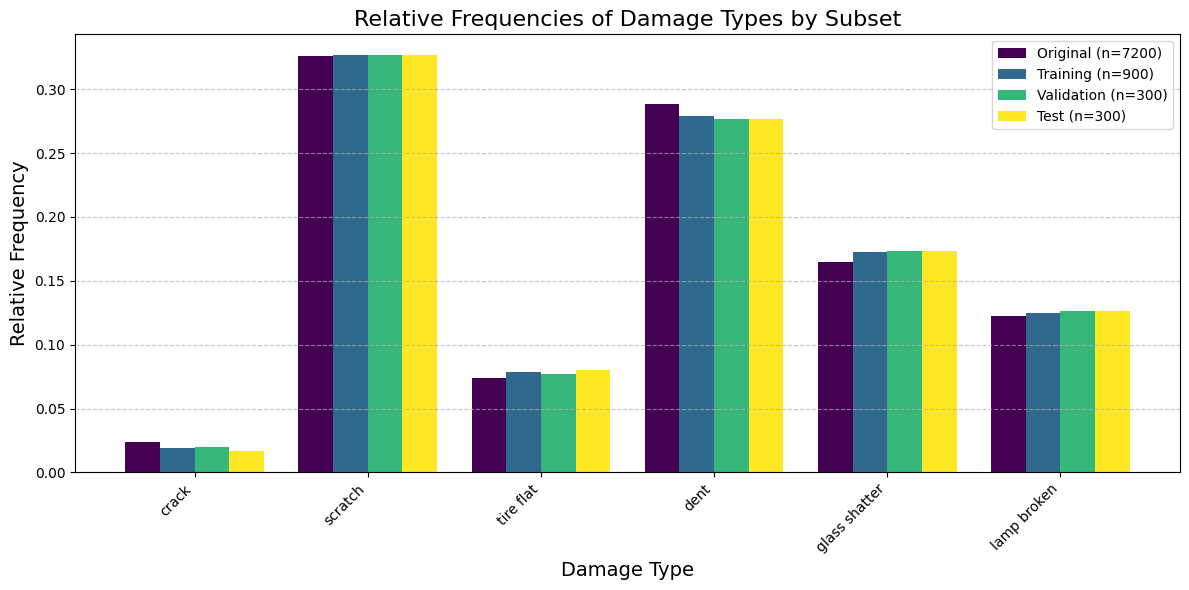

In [8]:
# Reuse the relative_freq function
def relative_freq(df, label_order):
    counts = df['label_text'].value_counts().reindex(label_order, fill_value=0)
    return counts / len(df)

# Compute relative frequencies
orig_freq  = relative_freq(df,        label_order)
train_freq = relative_freq(df_train,  label_order)
val_freq   = relative_freq(df_val,    label_order)
test_freq  = relative_freq(df_test,   label_order)

# Sample sizes for legend
n_orig  = len(df)
n_train = len(df_train)
n_val   = len(df_val)
n_test  = len(df_test)

# Positions for four bars per group
x     = np.arange(len(label_order))
width = 0.2

# Use Viridis colormap and select evenly spaced colors
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

fig, ax = plt.subplots(figsize=(12, 6))

# Plot grouped bars with specified colors
ax.bar(x - 1.5*width, orig_freq,  width, color=colors[0], label=f'Original (n={n_orig})')
ax.bar(x - 0.5*width, train_freq, width, color=colors[1], label=f'Training (n={n_train})')
ax.bar(x + 0.5*width, val_freq,   width, color=colors[2], label=f'Validation (n={n_val})')
ax.bar(x + 1.5*width, test_freq,  width, color=colors[3], label=f'Test (n={n_test})')

# Customize axes and legend
ax.set_xlabel('Damage Type', fontsize=14)
ax.set_ylabel('Relative Frequency', fontsize=14)
ax.set_title('Relative Frequencies of Damage Types by Subset', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(label_order, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The similar distributions across the original dataset and the subsets confirm that the stratified sampling effectively maintains the overall class balance.

<h1 id="primary_objective_damage_type_classification" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">3. Primary Objective: Damage Type Classification</h1>

In this section, we address the primary objective of the case study: classifying the type of car damage based on image data. We explore different modeling approaches, starting from a traditional Convolutional Neural Network (CNN) to more advanced Large Language Models (LLMs) with vision capabilities. Our goal is to evaluate how these models perform on the classification task and to understand the benefits of leveraging vision-enabled LLMs in actuarial practice.

To systematically store and later evaluate the model predictions alongside the actual labels, we first initialize a data structure that holds the ground-truth labels from the test dataset. Predictions from the three models will be added in the following subsections.

In [9]:
# Initialize a results DataFrame with actual labels from the test set
results_df = pd.DataFrame({
    "filename": df_test["filename"],
    "actual_label_id": df_test["label_id"]
    # Predictions from different models will be added later
})

<h1 id="damage_classification_using_a_convolutional_neural_network"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.1 Damage Classification Using a Convolutional Neural Network
    <a class="anchor-link"
       href="#damage_classification_using_a_convolutional_neural_network"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

We begin by building a baseline model using a Convolutional Neural Network (CNN), a widely used deep learning architecture for image classification tasks. The CNN will serve as a benchmark for later comparisons against vision-enabled LLMs. In this subsection, we detail the model architecture, training procedure, and initial performance evaluation on the vehicle damage classification task.

The first step is to define and train a CNN architecture using the training and validation subsets. We base our model on *EfficientNet-B0*, a state-of-the-art CNN that balances accuracy and computational efficiency by scaling network depth, width, and resolution in a structured manner. By leveraging pretrained weights fine-tuned on large-scale image datasets, we achieve strong classification performance while minimizing training time. The goal here is not to create the optimal model but to establish a robust baseline with adequate predictive quality. Readers are encouraged to experiment with further refinements. For this implementation, we use PyTorch, a widely adopted deep learning library; alternatively, similar architectures can be built using TensorFlow and the Keras API.

In [10]:
# ============================================================
# 1. Custom Dataset Class
# ============================================================
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image filenames and labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = int(row['label_id'])
        if self.transform:
            image = self.transform(image)
        return image, label

# ============================================================
# 2. Transforms and DataLoaders
# ============================================================
# ImageNet normalization values.
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Create dataset instances
train_dataset = CustomImageDataset(df_train, image_folder, transform=train_transform)
val_dataset   = CustomImageDataset(df_val, image_folder, transform=val_test_transform)
test_dataset  = CustomImageDataset(df_test, image_folder, transform=val_test_transform)

# Create DataLoaders (using num_workers=0 to avoid multiprocessing issues)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ============================================================
# 3. Model Definition with Pretrained EfficientNet-B0
# ============================================================
# Use the updated API for torchvision EfficientNet weights
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT, progress=False)

# Replace the classifier layer to match the number of classes in our dataset
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# ============================================================
# 4. Define Loss Function and Optimizer
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 5. Training Loop
# ============================================================
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} ‖ "
            f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f} ‖ "
            f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

# ============================================================
# 6. Evaluation on Test Set
# ============================================================
model.eval()
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_dataset)
test_acc = test_corrects.double() / len(test_dataset)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Using device: cpu
Epoch 1/20 ‖ Train Loss: 1.6396 | Train Accuracy: 0.3611 ‖ Val Loss: 1.3940 | Val Accuracy: 0.5400
Epoch 2/20 ‖ Train Loss: 1.2945 | Train Accuracy: 0.5800 ‖ Val Loss: 1.0727 | Val Accuracy: 0.6667
Epoch 3/20 ‖ Train Loss: 1.0034 | Train Accuracy: 0.6667 ‖ Val Loss: 0.8198 | Val Accuracy: 0.7400
Epoch 4/20 ‖ Train Loss: 0.8481 | Train Accuracy: 0.7067 ‖ Val Loss: 0.6882 | Val Accuracy: 0.7867
Epoch 5/20 ‖ Train Loss: 0.7181 | Train Accuracy: 0.7667 ‖ Val Loss: 0.6122 | Val Accuracy: 0.8033
Epoch 6/20 ‖ Train Loss: 0.6622 | Train Accuracy: 0.7589 ‖ Val Loss: 0.5554 | Val Accuracy: 0.8333
Epoch 7/20 ‖ Train Loss: 0.5594 | Train Accuracy: 0.8033 ‖ Val Loss: 0.5065 | Val Accuracy: 0.8433
Epoch 8/20 ‖ Train Loss: 0.5722 | Train Accuracy: 0.7922 ‖ Val Loss: 0.4898 | Val Accuracy: 0.8233
Epoch 9/20 ‖ Train Loss: 0.5035 | Train Accuracy: 0.8244 ‖ Val Loss: 0.4914 | Val Accuracy: 0.8267
Epoch 10/20 ‖ Train Loss: 0.4268 | Train Accuracy: 0.8711 ‖ Val Loss: 0.4507 | Val Accuracy

The training progress shows a consistent decrease in loss and increase in accuracy, indicating effective learning. Validation metrics follow a similar trend but eventually stabilize, suggesting performance has plateaued. While techniques like early stopping or regularization could further refine the model, the final test results confirm satisfactory predictive quality.

To conclude this section, we compute the CNN's predictions on the test set and store them for later evaluation. The actual assessment of model performance using metrics such as accuracy and the weighted F1 score, both standard for multiclass classification tasks, will be conducted in [Subsection 3.4](#evaluating_and_comparing_model_performance).

In [11]:
# Helper function to get prediction from CNN (returns numeric class ID)
def get_cnn_damage_type_prediction(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label_id = predicted_class.item()  # Get integer class directly
    return predicted_label_id

# Initialize a list to store CNN predicted class IDs
cnn_predictions = []

# Loop over the test set and predict using CNN
for _, row in df_test.iterrows():
    image_path = os.path.join(image_folder, row["filename"])
    prediction = get_cnn_damage_type_prediction(image_path, model, val_test_transform, device)
    cnn_predictions.append(prediction)

# Add CNN predictions to the results DataFrame
results_df["cnn_predicted_label_id"] = cnn_predictions

<h1 id="damage_classification_using_a_non-fine-tuned_large_language_model"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.2 Damage Classification Using a Non-Fine-Tuned Large Language Model
    <a class="anchor-link"
       href="#damage_classification_using_a_non-fine-tuned_large_language_model"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

After evaluating a traditional CNN approach, we now explore the use of a non-fine-tuned Large Language Model for the damage classification task. Specifically, we employ an off-the-shelf version of GPT-4o, a multimodal model inherently equipped with vision capabilities, to predict the type of vehicle damage directly from the image data.

To enable GPT-4o to process the images, we first encode them into a base64 string representation, converting the binary image data into a text format suitable for model input. The following function implements this encoding step, preparing the images for subsequent processing by the model.

In [12]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

Before making predictions with GPT-4o, we define a system prompt that will be provided during each model call. This prompt clearly instructs the LLM to classify the damage type visible in the image into exactly one of the six predefined categories. It emphasizes strict adherence to the specified output format to ensure consistency and accuracy across all predictions.

In [13]:
SYSTEM_PROMPT = """
You will classify images of cars with visible damages into one of six specific classes.
Your task is to examine the image provided, identify the type of damage, and return the correct damage type as one of the predefined classes.
The six damage classes are as follows:

1. crack
2. scratch
3. tire flat
4. dent
5. glass shatter
6. lamp broken

# Steps

1. **Analyze the Image:**
   - Carefully inspect the image provided, focusing on visible damage to determine its type.
   - Pay attention to details such as patterns, locations, and characteristics of the damage to accurately classify it.

2. **Identify the Correct Class:**
   - Match the observed damage to one of the six predefined classes listed above.
   - Avoid ambiguous classifications and ensure the answer aligns precisely with the provided options.

3. **Output the Classification:**
   - Provide your answer in a concise format with **only the name of the damage class** (e.g., "scratch").
   - Do not add any additional text, reasoning, or explanations. The response must be exactly one of the six class names.

# Notes
- If multiple damage types appear equally prominent in the image, select the one that seems most severe or predominant.
- Ensure every response falls strictly within the six defined classes. Avoid assumptions or interpretations beyond the scope of these categories.

# Example Format
For an input image with a visible scratch:
- Correct Output: "scratch"

For an input image showing a shattered glass window:
- Correct Output: "glass shatter"

Adhere to this strict output format and guidelines in every classification.
"""

Although the system prompt instructs the LLM to return one of the six specified damage types, variations in the output (e.g., different quotation styles such as `scratch`, `'scratch'`, or `"scratch"`) may occur. To enforce a consistent and strict output format, we employ the concept of [Structured Outputs](https://platform.openai.com/docs/guides/structured-outputs?api-mode=responses). The code below uses Pydantic's BaseModel, a convenient way to define a structured response schema in JSON format, ensuring that the prediction is strictly limited to one of the six damage classes.

In [14]:
# Define the response format for the OpenAI model using Structured Outputs
class DamageType(BaseModel):
    prediction: Literal["crack", "scratch", "tire flat", "dent", "glass shatter", "lamp broken"]

In the following function, we query an LLM with vision capabilities by providing the base64-encoded textual representation of an image, along with the previously defined system prompt and Structured Outputs (via the `response_format` parameter), to predict the corresponding damage type.

In [15]:
# Helper function to get prediction from an OpenAI model
def get_llm_image_prediction(encoded_image, model_name, system_prompt):
    """
    Queries an LLM with vision capabilities to predict a label from an encoded image.
    """
    try:
        response = client.beta.chat.completions.parse(
            model=model_name,
            messages=[
                {"role": "system", "content": [{"type": "text", "text": system_prompt}]},
                {"role": "user", "content": [{"type": "image_url", 
                                              "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}", 
                                                            "detail": "low"}}]}
            ],
            response_format=DamageType
        )
        return response.choices[0].message.parsed.prediction
    except Exception as e:
        print(f"Error getting prediction from model '{model_name}': {e}")
        return None

Below, we obtain predictions for each test image using the non-fine-tuned, off-the-shelf GPT-4o. Each image is encoded in base64, the LLM's textual output is then mapped back to its corresponding label ID via a reverse mapping, and the resulting predictions are stored in our results DataFrame for later evaluation.

In [16]:
# Set model name of the non-fine-tuned LLM
non_fine_tuned_llm_model = "gpt-4o-2024-08-06"

# Create a reverse mapping from label text to label ID
label_text_to_id = {v: k for k, v in label_mapping.items()}

# Obtain non-fine-tuned LLM predictions for each test image
non_fine_tuned_predictions = []
for _, row in df_test.iterrows():
    image_path = os.path.join(image_folder, row['filename'])
    encoded_image = encode_image(image_path)
    
    # Retrieve the non-fine-tuned LLM's prediction (as label text)
    pred_label_text = get_llm_image_prediction(encoded_image, non_fine_tuned_llm_model, SYSTEM_PROMPT)
    
    # Map the predicted label text back to its corresponding label ID
    pred_label_id = label_text_to_id.get(pred_label_text, None)
    non_fine_tuned_predictions.append(pred_label_id)

# Store the non-fine-tuned LLM predictions in the results DataFrame
results_df["non_fine_tuned_llm_predicted_label_id"] = non_fine_tuned_predictions

<h1 id="damage_classification_using_a_fine-tuned_large_language_model"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.3 Damage Classification Using a Fine-Tuned Large Language Model
    <a class="anchor-link"
       href="#damage_classification_using_a_fine-tuned_large_language_model"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

We now proceed to fine-tune the off-the-shelf GPT-4o model using domain-specific data to enhance its classification performance. The first step is to structure the dataset in the required JSONL format, which is necessary for OpenAI's fine-tuning platform. Each training example is formatted as a sequence of messages, including a system prompt defining the classification task, a user message containing the base64-encoded image, and, optionally, an assistant message with the ground truth label. The function below generates such JSONL files:

In [17]:
def create_jsonl(input_df, img_folder_path, output_file, include_assistant=True):
    """
    Generates a JSONL file from the input DataFrame.

    Parameters:
    - input_df: DataFrame containing the input data.
    - img_folder_path: Path to the folder containing the images.
    - output_file: Output JSONL file path.
    - include_assistant: Boolean to determine if the assistant message is included.
    """
    json_data = []

    for idx, row in tqdm(input_df.iterrows(), total=len(input_df)):
        # Encode the image in base64 format
        image_path = os.path.join(img_folder_path, row['filename'])
        encoded_image = encode_image(image_path)
        
        # System message
        system_message = {
            "role": "system",
            "content": [{"type": "text", "text": SYSTEM_PROMPT}]
        }
        
        # User message (image input)
        user_message = {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}", "detail": "low"}}
            ]
        }
        
        # Combine system and user messages
        all_messages = [system_message, user_message]

        # Add assistant message if specified
        if include_assistant:
            assistant_message = {
                "role": "assistant",
                "content": [{"type": "text", "text": row["label_text"]}]
            }
            all_messages.append(assistant_message)
        
        # Add to JSON data
        json_data.append({"messages": all_messages})

    # Save to JSONL file
    with open(output_file, "w") as file:
        for entry in json_data:
            file.write(json.dumps(entry) + "\n")

Next, we generate JSONL files for each data split – training, validation, and test. The training and validation files include both the user messages (base64-encoded images) and the assistant messages (ground truth labels), enabling the model to learn from labeled data. The test file, however, excludes the assistant messages, as it is intended solely for evaluation during the fine-tuning process.

In [18]:
# Create JSONL for the training dataset
create_jsonl(
    input_df=df_train,
    img_folder_path=image_folder,
    output_file="visual_fine_tuning_train.jsonl",
    include_assistant=True
)

# Create JSONL for the validation dataset
create_jsonl(
    input_df=df_val,
    img_folder_path=image_folder,
    output_file="visual_fine_tuning_validation.jsonl",
    include_assistant=True
)

# Create JSONL for the test dataset without assistant messages
create_jsonl(
    input_df=df_test,
    img_folder_path=image_folder,
    output_file="visual_fine_tuning_test.jsonl",
    include_assistant=False
)

100%|██████████| 300/300 [00:00<00:00, 1490.97it/s]


If we decide to proceed with fine-tuning, we can upload the training and validation JSONL files to the OpenAI platform and initiate the fine-tuning job using the vision-enabled GPT-4o model. The code snippet below demonstrates how to upload these files and start the fine-tuning process, which only runs if the `create_fine_tuning_job` flag is set to `True`.

In [19]:
create_fine_tuning_job = False
if create_fine_tuning_job:
    # upload training file
    train_file = client.files.create(
        file=open("visual_fine_tuning_train.jsonl", "rb"),
        purpose="fine-tune"
    )

    # upload validation file
    val_file = client.files.create(
        file=open("visual_fine_tuning_validation.jsonl", "rb"),
        purpose="fine-tune"
    )

    # create fine tuning job
    client.fine_tuning.jobs.create(
        training_file=train_file.id,
        validation_file=val_file.id,
        model="gpt-4o-2024-08-06"
    )

To conclude this subsection, we use the fine-tuned LLM to generate predictions for each test image. Each image is encoded to base64 and processed using the same prediction function as for the non-fine-tuned model. The resulting output text is then mapped back to its corresponding label ID and stored in the `results_df` DataFrame.

In [20]:
# Set model name of the fine-tuned LLM
fine_tuned_llm_model = "ft:gpt-4o-2024-08-06:personal::B5swMoBf"

# Obtain fine-tuned LLM predictions for each test image
fine_tuned_predictions = []
for _, row in df_test.iterrows():
    image_path = os.path.join(image_folder, row['filename'])
    encoded_image = encode_image(image_path)
    
    # Retrieve the fine-tuned LLM's prediction (as label text)
    pred_label_text = get_llm_image_prediction(encoded_image, fine_tuned_llm_model, SYSTEM_PROMPT)
    
    # Map the predicted label text back to its corresponding label ID
    pred_label_id = label_text_to_id.get(pred_label_text, None)
    fine_tuned_predictions.append(pred_label_id)

# Store the fine-tuned LLM predictions in the results DataFrame
results_df["fine_tuned_llm_predicted_label_id"] = fine_tuned_predictions

<h1 id="evaluating_and_comparing_model_performance"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.4 Evaluating and Comparing Model Performance
    <a class="anchor-link"
       href="#evaluating_and_comparing_model_performance"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

Finally, we evaluate model performance through accuracy and weighted F1 score to quantify predictive quality and account for class imbalances, with the latter assigning greater weight to more frequent classes. We then analyze confusion matrices to identify well-classified damage types and common misclassifications, followed by a closer look at a few test images where the non-fine-tuned and fine-tuned LLMs produce differing predictions.

We begin by calculating these metrics for each model and summarizing the results in a comparative table.

In [21]:
# Extract labels
actual_labels = results_df["actual_label_id"]
cnn_labels = results_df["cnn_predicted_label_id"]
non_fine_tuned_labels = results_df["non_fine_tuned_llm_predicted_label_id"]
fine_tuned_labels = results_df["fine_tuned_llm_predicted_label_id"]

# Compute accuracy and weighted F1-score, rounded to three decimal places
metrics = {
    "Model": ["PyTorch Model", "Non-Fine-Tuned GPT", "Fine-Tuned GPT"],
    "Accuracy": [
        round(accuracy_score(actual_labels, cnn_labels), 3),
        round(accuracy_score(actual_labels, non_fine_tuned_labels), 3),
        round(accuracy_score(actual_labels, fine_tuned_labels), 3)
    ],
    "Weighted F1 Score": [
        round(f1_score(actual_labels, cnn_labels, average="weighted"), 3),
        round(f1_score(actual_labels, non_fine_tuned_labels, average="weighted"), 3),
        round(f1_score(actual_labels, fine_tuned_labels, average="weighted"), 3)
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Accuracy,Weighted F1 Score
0,PyTorch Model,0.837,0.835
1,Non-Fine-Tuned GPT,0.823,0.825
2,Fine-Tuned GPT,0.880,0.880


The fine-tuned GPT model achieves the highest accuracy and weighted F1 score, indicating its superior predictive performance compared to both the CNN model and the non-fine-tuned GPT model.

Next, we generate confusion matrices for all three models to visually assess how well each model distinguishes between the different damage classes. This analysis helps to pinpoint specific classes where the models perform well and identify classes where misclassifications are more frequent.

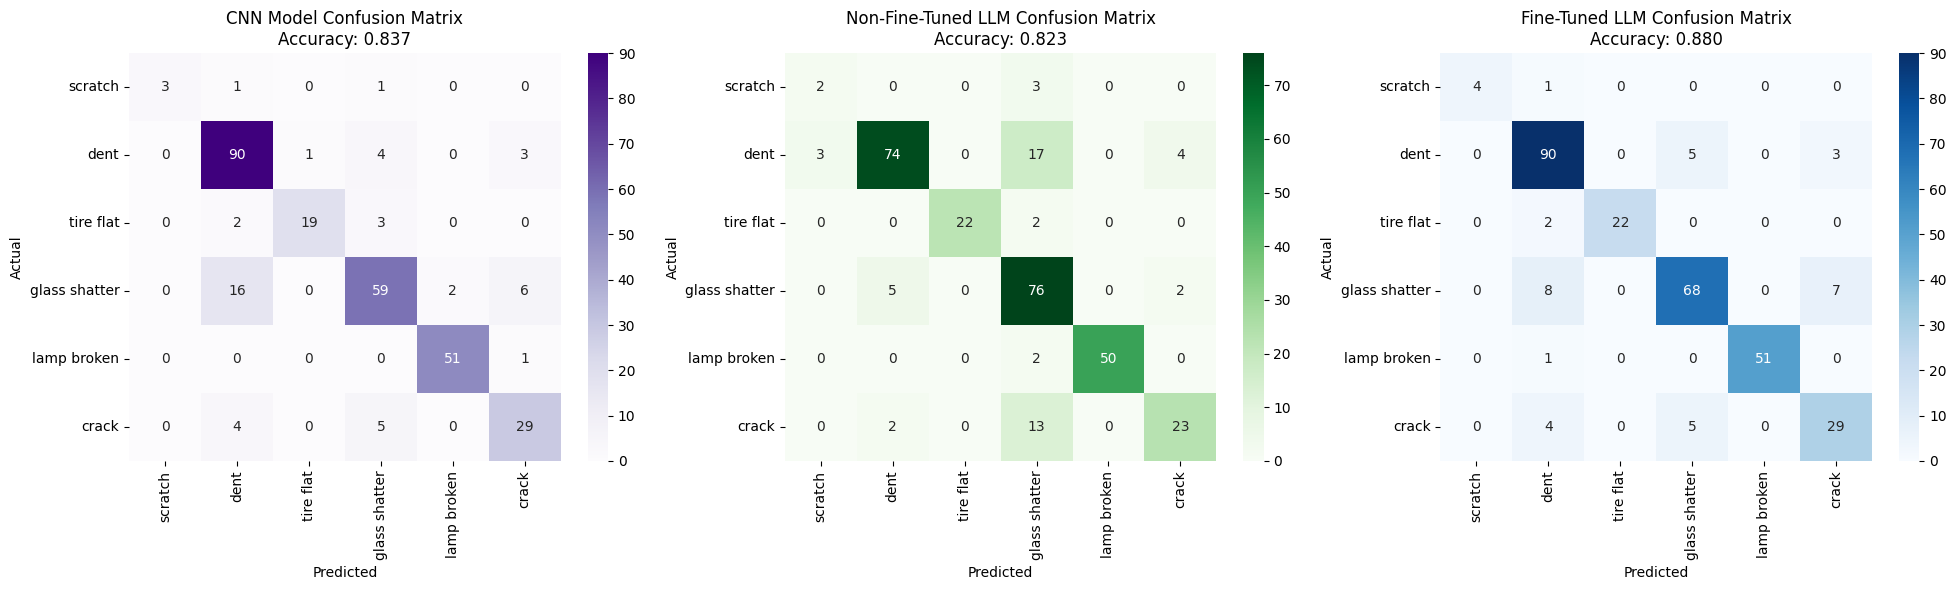

In [22]:
# Compute confusion matrices
cnn_cm = confusion_matrix(actual_labels, cnn_labels)
non_fine_tuned_cm = confusion_matrix(actual_labels, non_fine_tuned_labels)
fine_tuned_cm = confusion_matrix(actual_labels, fine_tuned_labels)

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Define common label names
label_names = df_test['label_text'].unique()

# CNN Confusion Matrix
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Purples', ax=axs[0], 
            xticklabels=label_names, yticklabels=label_names)
axs[0].set_title(f"CNN Model Confusion Matrix\nAccuracy: {accuracy_score(actual_labels, cnn_labels):.3f}")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# Non-Fine-Tuned LLM Confusion Matrix
sns.heatmap(non_fine_tuned_cm, annot=True, fmt='d', cmap='Greens', ax=axs[1], 
            xticklabels=label_names, yticklabels=label_names)
axs[1].set_title(f"Non-Fine-Tuned LLM Confusion Matrix\nAccuracy: {accuracy_score(actual_labels, non_fine_tuned_labels):.3f}")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

# Fine-Tuned LLM Confusion Matrix
sns.heatmap(fine_tuned_cm, annot=True, fmt='d', cmap='Blues', ax=axs[2], 
            xticklabels=label_names, yticklabels=label_names)
axs[2].set_title(f"Fine-Tuned LLM Confusion Matrix\nAccuracy: {accuracy_score(actual_labels, fine_tuned_labels):.3f}")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

All three models excel at identifying clear-cut classes like `lamp broken` and `dent` but commonly confuse subtler damage types such as `crack`, `scratch`, and `glass shatter`. Fine-tuning the LLM sharply reduces these ambiguous errors – particularly between `dent` and `glass shatter` – resulting in much clearer separation of similar classes compared to the non-fine-tuned version.

Next, we visualize a sample of test images along with their corresponding predictions from all three models. This visual inspection provides an intuitive overview of the model outputs and helps identify areas where the models might struggle or excel.

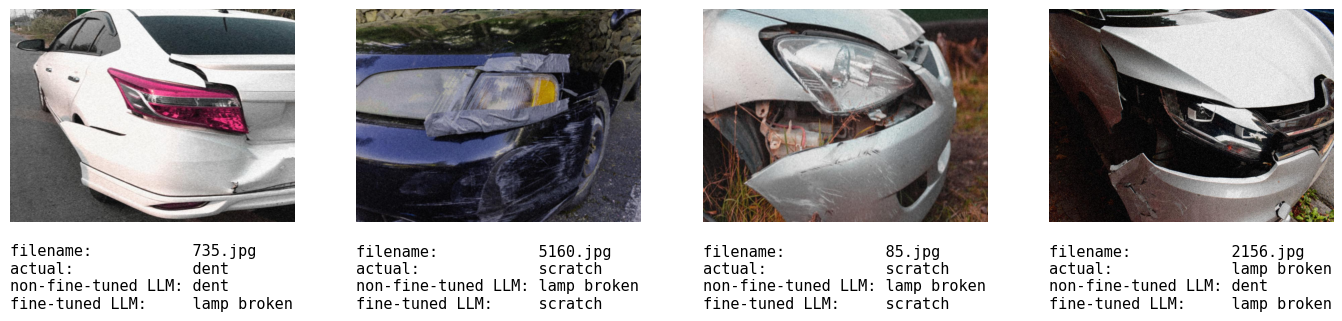

In [34]:
# Find and select up to four disagreement examples
disagreements = results_df[
    results_df['non_fine_tuned_llm_predicted_label_id'] 
    != results_df['fine_tuned_llm_predicted_label_id']
].sample(4, random_state=RANDOM_SEED).reset_index(drop=True)

# Prepare figure grid
num_examples = len(disagreements)
fig, axes = plt.subplots(1, num_examples, figsize=(14,8))

# Ensure axes is iterable even if there's only one example
if num_examples == 1:
    axes = [axes]

# 3. Display each image with label-text annotations
for idx, (_, row) in enumerate(disagreements.iterrows()):
    ax = axes[idx]
    img_path = os.path.join(image_folder, row["filename"])
    
    # Load and show the image
    with Image.open(img_path) as img:
        ax.imshow(img)
    ax.axis("off")
    
    # Convert IDs to text
    actual_text      = label_mapping[row['actual_label_id']]
    non_tuned_text   = label_mapping[row['non_fine_tuned_llm_predicted_label_id']]
    fine_tuned_text  = label_mapping[row['fine_tuned_llm_predicted_label_id']]
    
    # Create and add annotation
    annotation = (
        f"filename:           {row['filename']}\n"
        f"actual:             {actual_text}\n"
        f"non-fine-tuned LLM: {non_tuned_text}\n"
        f"fine-tuned LLM:     {fine_tuned_text}"
    )
    ax.text(
        0, -0.1, annotation,
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="left",
        family="monospace",
        wrap=True
    )

plt.tight_layout()
plt.show()

The example images show that fine-tuning helps the LLM correctly resolve ambiguous cases where multiple damage types overlap. By training on domain-specific data, the model’s ability to distinguish and accurately classify complex damage scenarios is significantly improved.

<h1 id="secondary_objective_identifying_damage_location" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">4. Secondary Objective: Identifying Damage Location</h1>

Beyond classifying the type of damage, a secondary objective of this project is to also pinpoint where on the car the damage is located. Being able to automatically identify not only *what* kind of damage has occurred, but also *where* it is situated, adds valuable context that can significantly enhance applications like insurance assessments, repair cost estimations, and car condition reporting.
In this section, we introduce an adapted system prompt that expands the model's task: instead of predicting only the damage class, it must now additionally output the damage location when identifiable. The following prompt instructs the model to perform this extended task while adhering to a strict output format to maintain consistency.

To extend the model's capabilities, we modify the system prompt so that it includes both the damage type and, if possible, the damage location. The structure of the new prompt remains similar to the earlier version used for damage classification alone but now emphasizes that location information should be included when it is clearly observable.

In [24]:
SYSTEM_PROMPT_incl_location = """
You will classify images of cars with visible damages into one of six specific classes.
Your task is to examine the image provided, identify the type of damage, and return the correct damage type as one of the predefined classes.
Additionally, if the location of the damage is identifiable, specify it concisely.
The six damage classes are as follows:

1. crack
2. scratch
3. tire flat
4. dent
5. glass shatter
6. lamp broken

# Steps

1. **Analyze the Image:**
   - Carefully inspect the image provided, focusing on visible damage to determine its type.
   - Pay attention to details such as patterns, locations, and characteristics of the damage to classify it accurately.

2. **Identify the Correct Class:**
   - Match the observed damage to one of the six predefined classes listed above.
   - Avoid ambiguous classifications and ensure the answer aligns precisely with the provided options.

3. **Determine and Output the Classification and Location:**
   - If the damage location is clear (e.g., "windshield" for glass shatter or "rear bumper" for a dent), include it in the response.
   - If the location cannot be determined with confidence, return only the damage class.

# Output Format:
- If the location is identifiable: `"damage type at location"` (e.g., `"glass shatter at windshield"`)
- If the location is unclear: `"damage type"` (e.g., `"scratch"`)

# Notes
- If multiple damage types appear equally prominent in the image, select the one that seems most severe or predominant.
- Ensure every response falls strictly within the six defined classes. Avoid assumptions or interpretations beyond these categories.

# Example Outputs:
For an input image with a visible scratch:
- **Correct Output:** `"scratch"`

For an input image showing a shattered windshield:
- **Correct Output:** `"glass shatter at windshield"`

For an input image with an unclear damage location:
- **Correct Output:** `"dent"`

Adhere strictly to this output format and classification criteria in every response.
"""


To accommodate the extended task of predicting both the damage type and its location, we define a new response format that builds upon the previous structure used for damage classification. This updated format includes an optional `location` field, allowing the model to provide additional spatial information when available while retaining the core damage type prediction.

In [25]:
class DamageTypeAndLocation(BaseModel):
    prediction: Literal["crack", "scratch", "tire flat", "dent", "glass shatter", "lamp broken"]
    location: Optional[str]

Similar to the previous section, we implement a helper function to query the vision-capable LLM and retrieve structured predictions. However, in this case, the function is adapted to also extract the optional damage location information, in line with the extended response format defined earlier.

In [26]:
# Helper function to get prediction from an OpenAI model
def get_llm_image_prediction_incl_location(encoded_image, model_name, system_prompt):
    """
    Queries an LLM with vision capabilities to predict a damage type and optionally a location from an encoded image.
    """
    try:
        response = client.beta.chat.completions.parse(
            model=model_name,
            messages=[
                {"role": "system", "content": [{"type": "text", "text": system_prompt}]},
                {"role": "user", "content": [{"type": "image_url", 
                                              "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}", 
                                                            "detail": "low"}}]}
            ],
            response_format=DamageTypeAndLocation
        )
        return response.choices[0].message.parsed.prediction, response.choices[0].message.parsed.location
    except Exception as e:
        print(f"Error getting prediction from model '{model_name}': {e}")
        return None, None

To better understand how the model predicts both the damage type and location, we select a few example images and visualize the results. For each image, we display the actual label along with the model's predicted damage type and, when possible, the identified damage location. This allows us to qualitatively assess the model's behavior and consistency across different cases.

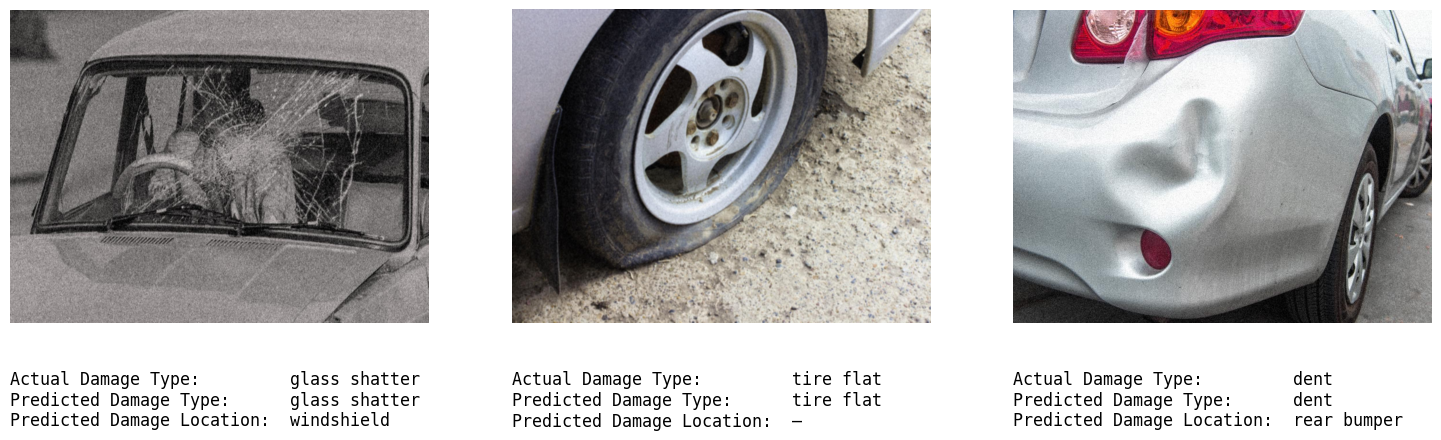

In [30]:
# List of specific images to display
image_filenames = ['66.jpg', '429.jpg', '737.jpg']

# Prepare to display the images and predictions in a 1x3 grid
num_cols = len(image_filenames)
fig, axs = plt.subplots(1, num_cols, figsize=(15, 8))

# Iterate over the selected image filenames
for idx, filename in enumerate(image_filenames):
    # Get the image path and encode the image
    image_path = os.path.join(image_folder, filename)
    encoded_image = encode_image(image_path)

    # Get predictions from the fine-tuned model
    predicted_label, predicted_location = get_llm_image_prediction_incl_location(
        encoded_image, fine_tuned_llm_model, SYSTEM_PROMPT_incl_location
    )

    # Display the image in the correct subplot
    with Image.open(image_path) as img:
        axs[idx].imshow(img)
        axs[idx].axis('off')
    
    # Fetch the actual label from the results DataFrame
    actual_label = df.loc[df['filename'] == filename, 'label_text'].values[0]

    axs[idx].text(
        0, -0.15,
        f"Actual Damage Type:         {actual_label}\n"
        f"Predicted Damage Type:      {predicted_label}\n"
        f"Predicted Damage Location:  {predicted_location if predicted_location is not None else '–'}",
        fontsize=12,
        va='top',
        ha='left',
        transform=axs[idx].transAxes,
        wrap=True,
        fontfamily='monospace'
    )

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The model correctly identifies the damage locations – for example, indicating that the glass shatter is on the windshield and the dent is on the rear bumper – while in one case (tire flat), the specific tire could not be determined. Note that since the dataset does not include damage locations, the correctness of the predictions has to be verified manually.